<a href="https://colab.research.google.com/github/JHWannabe/Self_Directed_Project/blob/main/Exercise_to_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.layers import Dense, Conv2DTranspose, LeakyReLU, Reshape, BatchNormalization, Activation, Conv2D
from keras.models import Model, Sequential

In [ ]:
def generador_de_imagenes():

    generador = Sequential()

    generador.add(Dense(256*4*4, input_shape = (100,)))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU())
    generador.add(Reshape((4,4,256)))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))


    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2DTranspose(128,kernel_size=3, strides=2, padding = "same"))
    #generador.add(BatchNormalization())
    generador.add(LeakyReLU(alpha=0.2))

    generador.add(Conv2D(3,kernel_size=3, padding = "same", activation='tanh'))

    return(generador)

modelo_generador = generador_de_imagenes()

modelo_generador.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4096)              413696    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 4096)              0         
                                                                 
 reshape (Reshape)           (None, 4, 4, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 8, 8, 128)        295040    
 nspose)                                                         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      147584    
 ranspose)                                              

Checking if the generative network works

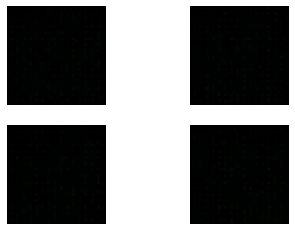

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Definir datos de entrada
def generar_datos_entrada(n_muestras):
  X = np.random.randn(100 * n_muestras)
  X = X.reshape(n_muestras, 100)
  return X

def crear_datos_fake(modelo_generador, n_muestras):
  input = generar_datos_entrada(n_muestras)
  X = modelo_generador.predict(input)
  y = np.zeros((n_muestras, 1))
  return X,y

numero_muestras = 4
X,_ = crear_datos_fake(modelo_generador, numero_muestras)

# Visualizamos resultados
for i in range(numero_muestras):
    plt.subplot(2, 2, 1 + i)
    plt.axis('off')
    plt.imshow(X[i])


Code the discriminator network  
Structure of the discriminator network

In [ ]:
from keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

def discriminador_de_imagenes():

    discriminador = Sequential()
    discriminador.add(Conv2D(64, kernel_size=3, padding = "same", input_shape = (32,32,3)))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(128, kernel_size=3,strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Conv2D(256, kernel_size=3, strides=(2,2), padding = "same"))
    discriminador.add(LeakyReLU(alpha=0.2))
    #discriminador.add(Dropout(0.2))

    discriminador.add(Flatten())
    discriminador.add(Dropout(0.4))
    discriminador.add(Dense(1, activation='sigmoid'))

    opt = Adam(lr=0.0002 ,beta_1=0.5)
    discriminador.compile(loss='binary_crossentropy', optimizer= opt , metrics = ['accuracy'])

    return(discriminador)

modelo_discriminador = discriminador_de_imagenes()
modelo_discriminador.summary()

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 4, 4, 256)        

Last steps to create a GAN in Python  
Load data from Cifar10

In [ ]:
from keras.datasets import cifar10

def cargar_imagenes():
    (Xtrain, Ytrain), (_, _) = cifar10.load_data()

    # Nos quedamos con los perros
    indice = np.where(Ytrain == 0)
    indice = indice[0]
    Xtrain = Xtrain[indice, :,:,:]

    # Normalizamos los datos
    X = Xtrain.astype('float32')
    X = (X - 127.5) / 127.5

    return X

print(cargar_imagenes().shape)

170508288/170498071 [==============================] - 13s 0us/step
(5000, 32, 32, 3)


Training the discriminator network

In [ ]:
import random

def cargar_datos_reales(dataset, n_muestras):
  ix = np.random.randint(0, dataset.shape[0], n_muestras)
  X = dataset[ix]
  y = np.ones((n_muestras, 1))
  return X,y

def cargar_datos_fake(n_muestras):
  X = np.random.rand(32 * 32 * 3 * n_muestras)
  X = -1 + X * 2
  X = X.reshape((n_muestras, 32,32,3))
  y = np.zeros((n_muestras, 1))
  return X,y

In [ ]:
def entrenar_discriminador(modelo, dataset, n_iteraciones=20, batch = 128):
  medio_batch = int(batch/2)

  for i in range(n_iteraciones):
    X_real, y_real = cargar_datos_reales(dataset, medio_batch)
    _, acc_real = modelo.train_on_batch(X_real, y_real)

    X_fake, y_fake = cargar_datos_fake(medio_batch)
    _, acc_fake = modelo.train_on_batch(X_fake, y_fake)

    print(str(i+1) + ' Real:' + str(acc_real*100) + ', Fake:' + str(acc_fake*100))

In [ ]:
dataset = cargar_imagenes()
entrenar_discriminador(modelo_discriminador, dataset)

1 Real:75.0, Fake:0.0
2 Real:100.0, Fake:6.25
3 Real:93.75, Fake:21.875
4 Real:92.1875, Fake:54.6875
5 Real:87.5, Fake:89.0625
6 Real:92.1875, Fake:98.4375
7 Real:90.625, Fake:100.0
8 Real:89.0625, Fake:100.0
9 Real:81.25, Fake:100.0
10 Real:79.6875, Fake:100.0
11 Real:93.75, Fake:100.0
12 Real:89.0625, Fake:100.0
13 Real:90.625, Fake:100.0
14 Real:96.875, Fake:100.0
15 Real:98.4375, Fake:100.0
16 Real:100.0, Fake:100.0
17 Real:98.4375, Fake:100.0
18 Real:93.75, Fake:100.0
19 Real:100.0, Fake:100.0
20 Real:100.0, Fake:100.0


Coding our generative adversarial network

In [ ]:
def crear_gan(discriminador, generador):
    discriminador.trainable=False
    gan = Sequential()
    gan.add(generador)
    gan.add(discriminador)

    opt = Adam(lr=0.0002,beta_1=0.5) 
    gan.compile(loss = "binary_crossentropy", optimizer = opt)

    return gan

gan = crear_gan(modelo_discriminador,modelo_generador)
gan.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 32, 32, 3)         1007363   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 522497    
                                                                 
Total params: 1,529,860
Trainable params: 1,007,363
Non-trainable params: 522,497
_________________________________________________________________


Model evaluation and image generation functions

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime

def mostrar_imagenes_generadas(datos_fake, epoch):

  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")

  # Hacemos que los datos vayan de 0 a 1
  datos_fake = (datos_fake + 1) / 2.0

  for i in range(10):
    plt.imshow(datos_fake[i])
    plt.axis('off')
    nombre = str(epoch) + '_imagen_generada_' + str(i) + '.png'
    plt.savefig(nombre, bbox_inches='tight')
    plt.close()

In [ ]:
def evaluar_y_guardar(modelo_generador, epoch, medio_dataset):

  # We save the model
  now = datetime.now()
  now = now.strftime("%Y%m%d_%H%M%S")
  nombre = str(epoch) + '_' + str(now)+"_modelo_generador_" + '.h5'
  modelo_generador.save(nombre)

  # We generate new data
  X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)
  X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

  # We evaluate the model
  _, acc_real = modelo_discriminador.evaluate(X_real, Y_real)
  _, acc_fake = modelo_discriminador.evaluate(X_fake, Y_fake)

  print('Acc Real:' + str(acc_real*100) + '% Acc Fake:' + str(acc_fake*100)+'%')

In [ ]:
def entrenamiento(datos, modelo_generador, modelo_discriminador, epochs, n_batch, inicio = 0):
  dimension_batch = int(datos.shape[0]/n_batch)
  medio_dataset = int(n_batch/2)

  # We iterate over the epochs
  for epoch in range(inicio, inicio + epochs):
    # We iterate over all batches
    for batch in range(n_batch):

      # We load all the real data
      X_real,Y_real = cargar_datos_reales(dataset, medio_dataset)


      # We train the discriminator withEnrenamos discriminador con datos reales
      coste_discriminador_real, _ = modelo_discriminador.train_on_batch(X_real, Y_real)
      X_fake, Y_fake =  crear_datos_fake(modelo_generador,medio_dataset)

      coste_discriminador_fake, _ = modelo_discriminador.train_on_batch(X_fake, Y_fake)

      # We generate input images for the GAN
      X_gan = generar_datos_entrada(medio_dataset)
      Y_gan = np.ones((medio_dataset, 1))

      # We train the GAN with fake data
      coste_gan = gan.train_on_batch(X_gan, Y_gan)

    # Every 10 epochs we show the results and cost 
    if (epoch+1) % 10 == 0:
      evaluar_y_guardar(modelo_generador,epoch = epoch, medio_dataset= medio_dataset)
      mostrar_imagenes_generadas(X_fake, epoch = epoch)

In [ ]:
entrenamiento(dataset, modelo_generador, modelo_discriminador, epochs = 300, n_batch=128, inicio = 0)

2/2 [==============================] - 0s 7ms/step - loss: 0.5115 - accuracy: 0.8594
Acc Real:78.125% Acc Fake:85.9375%


2/2 [==============================] - 0s 7ms/step - loss: 0.4617 - accuracy: 0.8906
Acc Real:65.625% Acc Fake:89.0625%


2/2 [==============================] - 0s 7ms/step - loss: 0.4748 - accuracy: 0.8906
Acc Real:59.375% Acc Fake:89.0625%


2/2 [==============================] - 0s 7ms/step - loss: 0.5651 - accuracy: 0.8125
Acc Real:65.625% Acc Fake:81.25%


2/2 [==============================] - 0s 8ms/step - loss: 0.4855 - accuracy: 0.8438
Acc Real:70.3125% Acc Fake:84.375%


2/2 [==============================] - 0s 7ms/step - loss: 0.4247 - accuracy: 0.8906
Acc Real:73.4375% Acc Fake:89.0625%


2/2 [==============================] - 0s 9ms/step - loss: 0.4210 - accuracy: 0.8906
Acc Real:75.0% Acc Fake:89.0625%


2/2 [==============================] - 0s 7ms/step - loss: 0.4216 - accuracy: 0.9375
Acc Real:85.9375% Acc Fake:93.75%


2/2 [==============================] - 0s 7ms/step - loss: 0.3720 - accuracy: 0.9062
Acc Real:89.0625% Acc Fake:90.625%


2/2 [==============================] - 0s 7ms/step - loss: 0.2362 - accuracy: 0.9844
Acc Real:73.4375% Acc Fake:98.4375%


KeyboardInterrupt: ignored

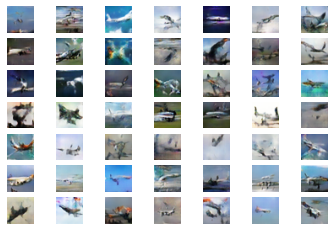

In [ ]:
X_fake, _ = crear_datos_fake(n_muestras=49, modelo_generador=modelo_generador)
X_fake = (X_fake+1)/2

for i in range(49):
  plt.subplot(7,7,i+1)
  plt.axis('off')
  plt.imshow(X_fake[i])